# Practical Machine Learning for Physicsists

## Generative Adversarial Networks

In this notebook we will introduce you to generative adversarial networks. In the time honoured tradition we will do this through the MNIST dataset (our favourite toy dataset).

This notebook is heavily inspired by the [TensorFlow tutorial on Deep Convolutional Generative Adversarial Networks.](https://www.tensorflow.org/tutorials/generative/dcgan). The code is basically the same as in the turorial although the commentary is slightly different. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense

import glob
import imageio
import os
import PIL
import time

from IPython import display

#Set default figure size
#mpl.rcParams['figure.figsize'] = [12.0, 8.0] #Inches... of course it is inches
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch

#Useful for debugging problems
print(tf.__version__)

2.3.1


## Step 1: Load and prepare the data
We first load and normalise the MINST handwritten digits dataset. Then we shuffle and batch up the dataset for easier digestion by TensorFlow.

Note that we are only using the training portion of the dataset, the testing portion isn't needed.

In [2]:
# Load the data
mnist = keras.datasets.mnist   #The original handwritten digit MNIST
#mnist = keras.datasets.fashion_mnist   #A tricky version that uses images of fashion items
(train_images, train_labels), (_, _) = mnist.load_data()

# Reshape the data
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]


In [3]:
# Example of tf dataset
BUFFER_SIZE = 60000
BATCH_SIZE = 256
NOISE_LENGTH = 100
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Step 2: Create our generator model
The generator model will try and turn random numbers into handwritten digit images. It will do this through a series of deconvolution and normalisation layers.
- [`tf.keras.layers.Conv2DTranspose`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) a transposed convolution layer (i.e. deconvolution)
- [`tf.keras.layers.BatchNormalization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) normalize and scale inputs and activations by subtracting the mean and dividing by the standard deviation
- [`tf.keras.layers.LeakyReLU`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LeakyReLU) a leaky version of ReLU, leaky means that for $x<0$ there is a small (i.e. non-zero) gradient



In [4]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(NOISE_LENGTH,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [5]:
generator=make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

(1, 28, 28, 1)


Text(0.5, 1.0, 'Generator before training')

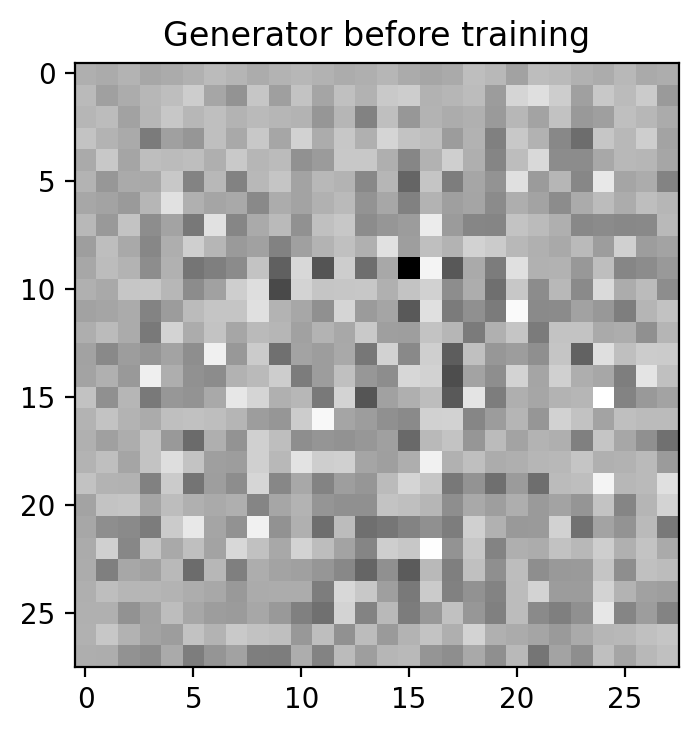

In [6]:
input=tf.random.normal([1,NOISE_LENGTH])
generated_image = generator(input, training=False)
print(generated_image.shape)

fig,ax = plt.subplots()
ax.imshow(generated_image[0,:,:,0],cmap='binary')
ax.set_title("Generator before training")


## Step 3: Make discriminator model
The discriminator model is going to be the standard Convolutional neural network.

In [7]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))

    return model

The discriminator is used to classify images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [8]:
discriminator = make_discriminator_model()
discriminator.summary()
decision = discriminator(generated_image)
print ("The decision on noise images:",decision)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

## Step 4: Define the loss
Now we define the loss, separately for both the discriminator and the generator.

In [9]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss
The discriminator loss is the measure of how well the discriminator can distinguish real images from fake images. So:
- The loss for real images is computed by comparing the discriminator output on real images against an array of 1's
- The loss for fake images is computed by comparing the discriminator output on fake images against an array of 0's

In [10]:
def discriminator_loss(real_output, fake_output):
    return cross_entropy(tf.ones_like(real_output),real_output) + cross_entropy(tf.zeros_like(fake_output),fake_output)

### Generator loss
The generator loss is the measure of well the generator can fool the discriminator into thinking that fake images are real. So
- The loss is computed by comparing the discriminator output on fake images against an array of 1's

In [11]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)

# Step 5: Define the optimisers
We will just use Adam

In [12]:
gen_optimiser=tf.keras.optimizers.Adam(1e-4)
dis_optimiser=tf.keras.optimizers.Adam(1e-4)

# Step 6: Use checkpoints to save progress during training
As we scale to bigger models that take longer to train it makes sense to start thinking about how we can save the results of our training for later use. If we save during the training then this can also help if our training becomes interuppted.

In [13]:
import os
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=gen_optimiser,
                                 discriminator_optimizer=dis_optimiser,
                                 generator=generator,
                                 discriminator=discriminator)

# Step 7: Define the training loop

The training loop should be something like:
1. Loop over epochs
    2. Loop over `BATCH_SIZE` batches of real images in training dataset
        1. Get `BATCH_SIZE` * `NOISE_LENGTH` random numbers
        2. Generate `BATCH_SIZE` fake images
        3. Run the discriminator over the real images
        4. Run the discrimnator over the fake images
        5. Compute the discriminator loss
        6. Compute the generator loss
        7. Get the gradients
        8. Update using the optimisers

Below we will use two forms of TensorFlow magic optimisation:
- [`@tf.function`](https://www.tensorflow.org/api_docs/python/tf/function) - 'compiles' the code for faster operation
- [`tf.GradientTape`](https://www.tensorflow.org/api_docs/python/tf/GradientTape) - Used to record operations for automatic differentiation  (look at the documentation link for further details)

In [14]:
EPOCHS = 50
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
test_seed = tf.random.normal([num_examples_to_generate, NOISE_LENGTH])

In [15]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_LENGTH])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_optimiser.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    dis_optimiser.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [16]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             test_seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           test_seed)

#### Generate and save images to produce an animated gif

In [17]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

# Step 8: Do the training
Now that we have set up all the training loops we can try and train our networks. Training GANs is challenging. As the two networks battle against each other it is important that they learn at a similar rate, if one gets on top too early than neither will learn efficiently.

This step is slow, on my (not so good) laptop it takes over two minutes per epoch.

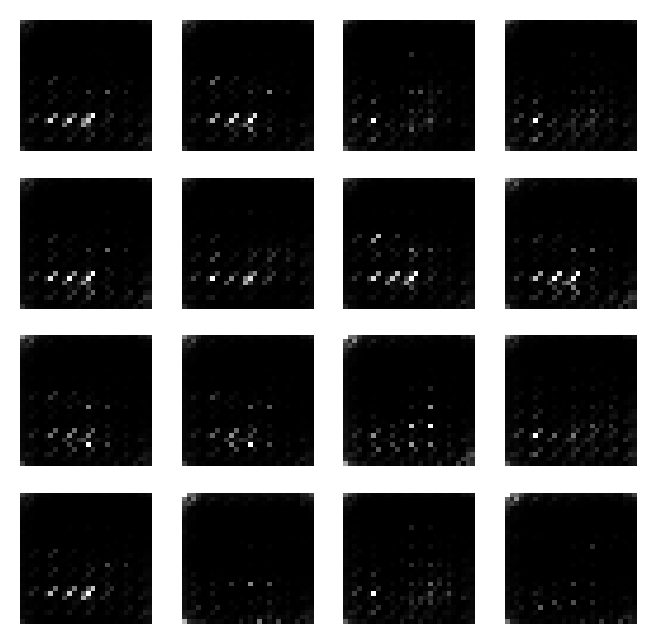

Time for epoch 2 is 172.89021492004395 sec


In [ ]:
train(train_dataset, EPOCHS)